In [2]:
%matplotlib ipympl
%config InlineBackend.figure_format='retina'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Output, Text
from IPython.display import display

from tesswcs import WCS
from tesswcs.utils import footprint
import astropy.units as u
from scipy.spatial.transform import Rotation as R
import warnings

In [4]:
def get_critical_angles(dlong, decl, roll):
    """
    Calculates the coordinates of the Sun in spacecraft coordinates.
    Routine implicitly assumes the Sun is at infinity, but this is likely a small effect

    Parameters:
    -----------
    dlong: float
        angle from antisolar of boresight
    decl: float
        ecliptic declination of pointing
    roll: float
        roll angle around the boresight

    Returns
    -------
    sign_x : float
        sign of the X coordinate of the Sun
    sun_angle: float
        the angle of the Sun above the sunshade in degrees
    sun_angle_SC: float
        the angle of the Sun in SC Y in degrees.
    """

    rlong = R.from_euler("x", -dlong, degrees=True)
    rlat = R.from_euler("y", -decl, degrees=True)
    rroll = R.from_euler("z", -roll, degrees=True)
    rfinal = rroll * rlat * rlong

    vsun = [0, 0, -1]
    vsunf = np.atleast_2d(rfinal.apply(vsun))

    return (
        np.sign(vsunf[:, 0]).astype(int),
        57.296 * np.arcsin(vsunf[:, 2]),
        57.296 * np.abs(np.arcsin(vsunf[:, 1])),
    )


def check_range(dlong, decl, roll, ylim=15, ndays=14):
    """
    Steps through the days of the sector, gives Z and Y angles and any alarms that might be set off.

    Parameters:
    -----------
    dlong: float
        the difference in ecliptic longitude from antisolar in the middle of the sector (0 for N-S orientations, but non-zero for ecliptic pointings),
    decl: float
        the ecliptic declination of the pointing
    roll: float
        the roll about S/C boresight (Z)
    ylim: float
        the antisolar angle limit set by NGSS. Default 15 degrees.
    ndays: float
        half the number of days in a sector (assumes that the sector is centered on anti-solar). Default 14 days.
    """
    for i in range(-ndays, ndays + 1, 1):
        ans = get_critical_angles(dlong + i, decl, roll)
        cx = cy = cz = ""
        if ans[0] < 0:
            cx = "Sun on -X"
        if ans[1] > -5:
            cz = "Sun above sunshade"
        if ans[2] > ylim:
            cy = "Sun > Y angle limit"

        print("%3d %2d %6.2f %6.2f %s %s %s" % (i, ans[0], ans[1], ans[2], cx, cy, cz))


def calculate_allowable_map(dlong, decl, roll, ylim=15, ndays=14):
    """
    Given a dlong, decl array, returns the array of booleans that shows if that set of parameters is allowable.

    Parameters:
    -----------
    dlong: float
        the difference in ecliptic longitude from antisolar in the middle of the sector (0 for N-S orientations, but non-zero for ecliptic pointings),
    decl: float
        the ecliptic declination of the pointing
    roll: float
        the roll about S/C boresight (Z)
    ylim: float
        the antisolar angle limit set by NGSS. Default 15 degrees.
    ndays: float
        half the number of days
    """
    dlong3, decl3 = np.asarray([dlong - ndays, dlong, dlong + ndays]), np.asarray(
        [decl, decl, decl]
    )
    if isinstance(roll, (float, int, np.integer)):        
        sign_x, sun_angle, sun_angle_SC = get_critical_angles(
            dlong3.ravel(), decl3.ravel(), roll
        )
    elif isinstance(roll, np.ndarray) & hasattr(roll, '__iter__'):
        roll3 = np.asarray(
            [roll, roll, roll]
        )
        sign_x, sun_angle, sun_angle_SC = get_critical_angles(
            dlong3.ravel(), decl3.ravel(), roll3.ravel()
        )
    else:
        raise ValueError(roll)
    allowable = (
        (
            (sign_x > 0)
            & (sun_angle < -5)  # positive X
            & (
                sun_angle_SC < ylim
            )  # sun below sunshade  # Y angle < NGCC critical angle
        )
        .reshape(dlong3.shape)
        .all(axis=0)
    )  # All true at beginning, middle, and end of sector.
    return allowable

In [8]:
dlong, decl = np.mgrid[-180:180, -90:90]
rolls = np.arange(-180, 180, 10)
r = []

a = np.zeros((dlong.shape[0], decl.shape[1], rolls.shape[0]))
for kdx, roll in enumerate(rolls):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        allowable = calculate_allowable_map(dlong, decl, roll)
    r.append(np.vstack([dlong[allowable], decl[allowable], np.ones(allowable.sum()) * roll]).T)
r = np.vstack(r)

# TESS Pointing Checker

The TESS spacecraft has criteria to determine what pointings are safe and power positive. This widget will help you visualize which pointings are allowable. The figure shows ecliptic coordinates, where the x axis shows the ecliptic longitude in degrees from the *anti-solar point*. (Here -180 degrees would be pointing directly at the Sun.) The y axis shows ecliptic latitude. The focal plane of TESS is shown overlaid, (note that Camera 1 has been highlighted as bolder than the other cameras, to give you an idea of which way round the spacecraft is.) Each observing sector for TESS is pointed towards the anti-solar point.

Pointings for TESS are prescribed by longitude, latitude, and roll. You can use the sliders to update these parameters and see how this impacts which regions of the sky will be observable. If the focal plane turns **blue**, that pointing does not violate TESS observing constraints. If the focal plane turns **red**, that pointing violates TESS observing constraints. 

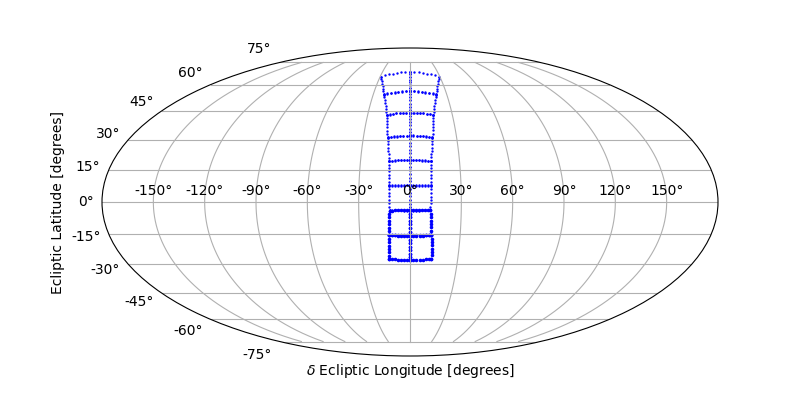

In [6]:
# Generate initial data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create the figure and axis
fig = plt.figure(figsize=(8, 4))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

ax = plt.subplot(111, projection="mollweide")

def get_color(dlong=0, decl=20, roll=0):
    k = r[:, 2] == roll
    if (np.isclose(dlong, r[:, 0][k]).any()) & (np.isclose(decl, r[:, 1][k]).any()):
        return 'blue'
    else:
        return 'red'

def plot(dlong=0, decl=20, roll=0):
    ax.clear()  # Clear the previous plot
    ax.grid(True)
    ax.set(
        xlabel="$\delta$ Ecliptic Longitude [degrees]",
        ylabel="Ecliptic Latitude [degrees]",
    )
    color = get_color(dlong, decl, roll)
    for camera in np.arange(1, 5):
        for ccd in np.arange(1, 5):
            wcs = WCS.predict(dlong, decl, roll, camera=camera, ccd=ccd)
            c = wcs.pixel_to_world(*footprint(npoints=8).T)
            if camera != 1:
                ax.scatter(c.ra.wrap_at(180 * u.deg).rad, c.dec.rad, c=color, s=0.5)
            else:
                ax.scatter(c.ra.wrap_at(180 * u.deg).rad, c.dec.rad, c=color, s=2.5)
            
    fig.canvas.draw_idle()
    
plot()
# Create a slider
slider1 = widgets.FloatSlider(value=0, min=-180, max=180, step=1, description='Delta Longitude:')
slider2 = widgets.FloatSlider(value=20, min=-90, max=90, step=1, description='Latitude:')
slider3 = widgets.FloatSlider(value=0, min=-180, max=180, step=10, description='Roll:')

# Update function
def update_plot(change):
    return 

# Update function
def update_plot(change):
    plot(slider1.value, slider2.value, slider3.value)

# Link the sliders to the update function
slider1.observe(update_plot, names='value')
slider2.observe(update_plot, names='value')
slider3.observe(update_plot, names='value')

# Reset function
def reset_parameters(b):
    slider1.value = 0
    slider2.value = -20
    slider3.value = 0


# Create an Output widget to hold the figure
output = Output()

# Create a reset button
reset_button = widgets.Button(description='Reset')
reset_button.on_click(reset_parameters)

# with output:
#     display(fig)


# Arrange the plot and slider in a layout
ui = VBox([output, HBox([VBox([slider1, slider2, slider3]), reset_button])])
display(ui)